In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import coordinates as coord
from astropy import constants, cosmology, units

import cdsed_modelling as colddust_sed_models

import scipy
from scipy.integrate import quad

import numpy as np
from astropy.io import fits
from astropy.table import Table


from IPython.display import display, Math

In [2]:
import sys; sys.executable

'/Users/robertatripodi/opt/anaconda3/bin/python'

In [3]:
# Insert here the redshift of the source. The unities to be used 
#are specified next to each quantity. Cosmology used is from Planck2018

z = 6.003
cosmop = cosmology.FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.726) 

D_l = cosmop.luminosity_distance(z).to('kpc').value #kpc
scale = cosmop.kpc_proper_per_arcmin(z).to('kpc/arcsec').value #kpc/"
c = constants.c.value #m/s
Msun = constants.M_sun.value #kg

#print(D_l, c, scale, Msun)

In [4]:
# Insert the area of the galaxy in kpc^2. Here, for instance, I put the FWHM sizes in arcsec^2

A = np.array([0.367*0.316,0.355*0.306])*np.pi*scale**2/4 #kpc^2
A = np.mean(A)

# Insert the observed frequency of your observations in GHz. If you want to put the rest-frame frequencies, 
#just adapt the code accordingly, leaving the mae of the variables unchanged

nu_obs = np.array([103.4014,239.2784,247.4335,248.4906,286.8863,325.7194,343.5505,462.8249]) #GHz

nu =  nu_obs*(1+z) #rest frame frequency, GHz
wave_obs = c*1e6/(nu_obs*1e9) #micrometer

# Insert the flux densities correspoding to the observed frequecies above in mJy and thei errors

flux = np.array([0.263,4.313,4.947,4.105,6.622,9.374,7.112,15.46]) #mJy 
err1 = np.array([0.033,0.041,0.062,0.086,0.084,0.086,0.043,0.33])  #mJy

#This is just for taking into account the calibration uncertainties that are added in quadrature 
# to err1 above. If this is not needed, comment the following two lines and rename the above err1 as flux_err

flux_err = colddust_sed_models.inizialize.calib_err(nu_obs, flux, err1)

# Set number of free paramters. It can be 1 or 2 or 3.

ndim = 2 

# Set which of the possible parameters (logMdust, beta, Tdust) will be set free in the modelling. 
#Useful if ndim is either 1 or 2.

sel_par = 0 #It can be 0, or 1, or 2.
#If ndim=1, par=0 corresponds to logMdust; par=1 to beta; par=2 to Tdust.
#If ndim=2, par=0 corresponds to [logMdust, beta]; par=1 to [logMdust, T]; par=2 to [beta, T].

part = colddust_sed_models.inizialize.type_free_par(ndim,sel_par) #in this example ndim=2, par=0
                                                              #therefore free parameter will be
                                                              #[logMdust, beta]

In [5]:
# Set the values of fixed paramters according to your needs. 
#The function fixing_order helps in setting fix_par

colddust_sed_models.inizialize.fixing_order(ndim,sel_par)

Td must be fixed. E.g., fix_par=[50]


In [6]:
# Set the values of fixed paramters according to your needs. 
##Example for ndim=2, par=0
fix_par = [50] #Tdust fixed --> log(Mdust/Msun), beta free

In [7]:
#Set the values for the starting position of the chain. It can be randomised.
#The function st_order helps in setting start_pos

colddust_sed_models.inizialize.st_order(ndim,sel_par)

LogMd, beta free. Keep the order. 
Example for start position of the walkers, start_pos=[8.,1.6]


In [8]:
start_pos = [8.,1.6] #example for ndim=2, par=0. Free [log10(Mdust/Msun), beta] 

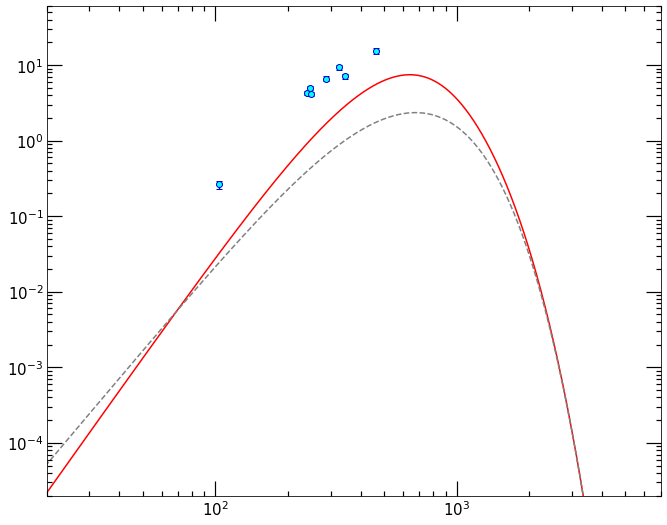

In [9]:
#Plot SED

font ='Times New Roman'

freq_plot = np.arange(10,8000) #GHz

ylim = [2e-5, 60]
xlim = [20,7000]
pos_text = [350,6]

wave_plot = c*1e6/(freq_plot*1e9) #micrometri

yd, yu = ylim
xd, xu = xlim

fig, ax = plt.subplots(figsize=(11,9))
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 15, color = 'k', top = True, right = True, labelsize = 15, width = 1.2)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5, top = True, right = True,width = 1.2)
plt.ylim(yd, yu)
ax.set_xlim(xd,xu)

ax.errorbar(nu_obs,flux, yerr = flux_err, capsize = 3, lw = 1.4, marker = 'o', ms =6, ls='none',color = 'cyan', markeredgecolor='mediumblue',ecolor='mediumblue', zorder =3)
model2 = colddust_sed_models.results_plot.sed_func_plot(freq_plot,nu_obs,part,[7.4,2.5],ndim,z,A,D_l,50)
model3 = colddust_sed_models.results_plot.sed_func_plot(freq_plot,nu_obs,part,[7.6,1.8],ndim,z,A,D_l,50)

ax.plot(freq_plot,model2, label = 'MBB', c = 'red', lw = 1.5, zorder =1)
ax.plot(freq_plot,model3, label = 'MBB', c = 'gray', ls='--',lw = 1.5, zorder =1)

In [10]:
#Here the chain is runned or imported (if previously runned)
#Always remember to remove the file .h5 if you want to run twice the same chain.

filename = 'test.h5' #change the filename as you wish. Here the chain will be saved

#For additional inputs in run_chain() see Readme.md
sampler = colddust_sed_models.sed_models.run_chain(start_pos, ndim,part,filename,nu_obs,\
                                                   flux,flux_err,z,D_l,A,fix_par,iteration=1000,run=False) 
print('Chain done')

Chain done


In [11]:
#Print the best-fitting values

cond = (ndim==1 and sel_par==0) or (ndim==2 and sel_par==0) or (ndim==2 and sel_par==1) #do not cahnge

if cond:
    popt, q, mdust = colddust_sed_models.results_plot.sed_results(sampler, ndim, sel_par, dis=250)
    print('M_dust/M_sun = %.2E - %.2E + %.2E' %(mdust[0], mdust[1], mdust[2]))
else:
    popt, q = colddust_sed_models.results_plot.sed_results(sampler, ndim, sel_par, dis=250)

label_new = colddust_sed_models.results_plot.labels(ndim,sel_par)

j = 0
for i in range(ndim):
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt2 = txt.format(popt[i], q[j], q[j+1], label_new[i])
    display(Math(txt2))
    j = j+2

M_dust/M_sun = 3.96E+08 - 8.64E+07 + 1.07E+08


<IPython.core.display.Math object>

<IPython.core.display.Math object>

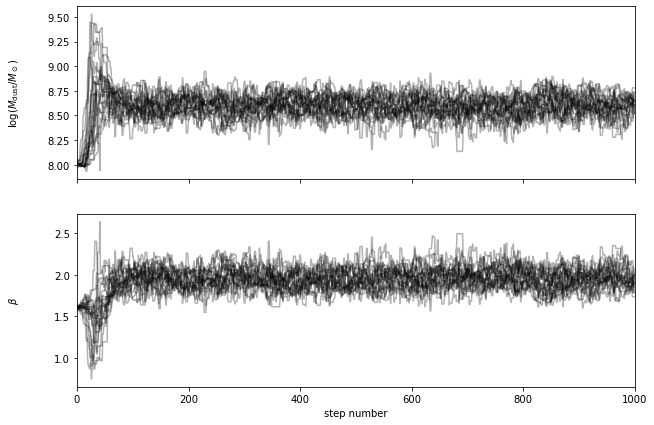

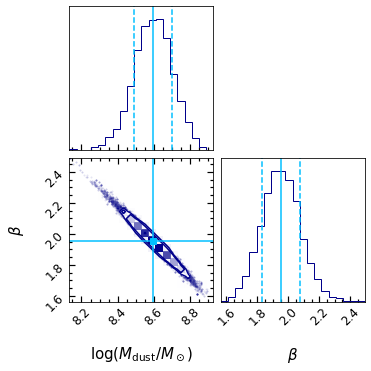

In [12]:
#Plot the chains and the corner plot

name = 'T50-beta16' 
colddust_sed_models.results_plot.sed_res_plot(sampler, ndim, name, part, sel_par, save=False)

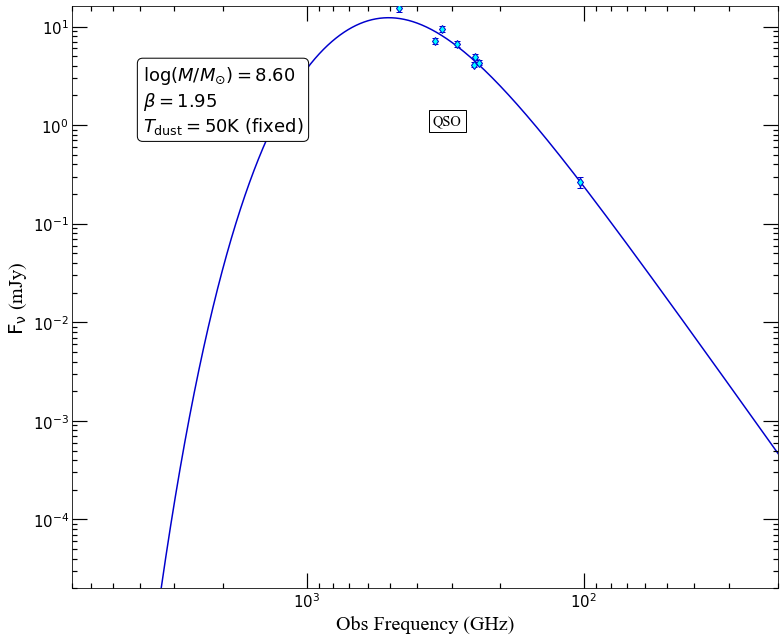

In [13]:
#Plot SED

freq_plot = np.arange(10,8000) #GHz
name_plot = 'QSO' 

ylim = [2e-5, 16]
xlim = [20,7000]
pos_text = [350,1]

colddust_sed_models.results_plot.plot_sed(freq_plot,sampler,part,sel_par,nu_obs,flux,flux_err,z,D_l,A,c,fix_par,\
                                          ndim,ylim,xlim,pos_text,name_plot,name,\
                                          display_res=True,save=False)


In [17]:
#Compute far-infrared luminosity (40-1000 microm) and associated SFR (using Chabrier IMF) from best-fit-values

LFIR, SFR = colddust_sed_models.results_plot.lfir_sfr_bestfit(popt,ndim,part,z,c,D_l,A,fix_par)

print('FIR Luminosity : %.3E L_sun' %(LFIR))
print('SFR: %.2f M_sun/yr' %(SFR))

#Compute total-infrared luminosity (8-1000 microm) and associated SFR (using Chabrier IMF) from best-fit-values
    
LTIR, SFR2 = colddust_sed_models.results_plot.ltir_sfr_bestfit(popt,ndim,part,z,c,D_l,A,fix_par)

print('TIR Luminosity : %.3E L_sun' %(LTIR))
print('SFR: %.2f M_sun/yr' %(SFR2))

FIR Luminosity : 7.644E+12 L_sun
SFR: 764.37 M_sun/yr
TIR Luminosity : 8.350E+12 L_sun
SFR: 835.04 M_sun/yr


In [14]:
#Compute far-infrared luminosity (40-1000 microm) and associated SFR (using Chabrier IMF) from chains

LFIR, SFR = colddust_sed_models.results_plot.lfir_sfr(sampler,ndim,part,z,c,D_l,A,fix_par)

LFIR_err = np.diff(LFIR)
SFR_err = np.diff(SFR)

print('FIR Luminosity : %.3E - %.3E + %.3E L_sun' %(LFIR[1],LFIR_err[0],LFIR_err[1]))
print('SFR: %.2f - %.2f +%.2f M_sun/yr' %(SFR[1],SFR_err[0],SFR_err[1]))

FIR Luminosity : 7.639E+12 - 1.125E+11 + 1.077E+11 L_sun
SFR: 763.86 - 11.25 +10.77 M_sun/yr


In [15]:
#Compute total-infrared luminosity (8-1000 microm) and associated SFR (using Chabrier IMF) from chains

LTIR, SFR2 = colddust_sed_models.results_plot.ltir_sfr(sampler,ndim,part,z,c,D_l,A,fix_par)

LTIR_err = np.diff(LTIR)
SFR2_err = np.diff(SFR2)

print('TIR Luminosity : %.3E - %.3E + %.3E L_sun' %(LTIR[1],LTIR_err[0],LTIR_err[1]))
print('SFR: %.2f - %.2f +%.2f M_sun/yr' %(SFR2[1],SFR2_err[0],SFR2_err[1]))

TIR Luminosity : 8.345E+12 - 1.124E+11 + 1.071E+11 L_sun
SFR: 834.54 - 11.24 +10.71 M_sun/yr
